# Data Wrangling

## Contents <a id='Contents'></a>

* [1 Introduction](#1_Introduction)
  * [1.1 Recap Of Data Science Problem](#1.1_Recap_Of_Data_Science_Problem)
  * [1.2 Imports](#1._Imports)
  * [1.3 Objectives](#1.3_Objectives)
  * [1.4 Approach](#1.4_Approach)
  * [1.5 Download the Data](#1.5_Download_Data)
  * [1.6 Save Raw Data](#1.5_Save_Raw_Data)
    - Here I save raw data with all features and rows, keep a copy for backup
* [2 Explore the Data](#2_Explore_The_Data)
  * [2.1 Overview](#2.1_Overview)
    * [2.1.1 Data Profile](#2.1.1_Data_Profile)
  * [2.2 Missing Values by Column](#2.2_Missing_Values_by_Column)
  * [2.2.1 Missing values - Findings](#2.2.2_Missing_Values_Findings)
  * [2.3 Review Variables](#2.3_Review_Variables)
    * [2.3.1 Location Data](#2.3.1_Location_Data) 
    * [2.3.2 Listing Data](#2.3.2_Listing_Data)
    * [2.3.3 Host Data](#2.3.3_Host_Data)
    * [2.3.4 Reviews Data](#2.3.4_Reviews_Data)
  * [2.4 Summary](#2.4_Summary)
    * [2.4.1 Strategy for EDA](#2.4.1_Strategy_for_EDA)
  * [2.5 Save Processed Data](#2.5_Save_Processed_Data)
  
  
Go to <a href=#bookmark>my bookmark</a>


## 1 Introduction<a id='1_Introduction'></a>

### 1.1 Recap Of Data Science Problem<a id='1.1_Recap_Of_Data_Science_Problem'></a>
The purpose of this project is to develop a pricing model for Airbnb listings in U.S. cities.
Airbnb wants to ensure that they are maximizing returns by recommending optimal prices to their hosts. They also want to monitor what features are most important to their guests.
This project aims to build a predictive model for listing price based on listings' location, amenities, and reputation for service. This model will be used to guide hosts in pricing their listings and planning improvements.

### 1.2 Imports<a id='1_Imports'></a>


In [1]:
#Import pandas, matplotlib.pyplot, and seaborn in the correct lines below
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import os
import numpy as np

#from library.sb_utils import save_file # I think this gets masked later?

from bs4 import BeautifulSoup # for scraping URLs to mass download data

# show output for multiple statements per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 1.3 Objectives<a id='1.3_Objectives'></a>



* Assemble dataset
  * Get data dictionary
* Review dataset
  * Dimensions
  * Feature types, data types, formatting
  * Missing values
  * Check if relevant data is present or missing
* Group features and prioritize
  * Assign all features to groups
    - Type of information provided
    - Expected importance
    - Formatting needed
    - Notes for feature engineering
  * Collect and drop unimportant features
* Save and summarize strategy for EDA and modelling
  

### 1.4 Approach<a id='1.4_Approach'></a>

**Overall approach**
* Load the data from insideairbnb
  * Check shape of data
  * Save Raw data file
* Review data dictionary
  - Note feature type, relevance, and group similar features
* Use pandas profiler for data overview:
  * Identify incomplete features
  * Feature formats and values
* Review features by group
  * List of features
  * Datatypes of features
  * Feature importance
  * Processing needed
  * Features to drop
* Save processed data
* Summarize Wrangling process and findings

**Specific datatypes to investigate**
* Dates
  * Convert to numeric vectors (time since...)
* Location
  * Coordinates: convert to distance
  * Location names: identify most useful, check for uniformity
* Descriptions
  * Importance, dataformat, identify processing and modelling approach


### 1.5 Download the Data<a id='1.5_Download_Data'></a>

**Data source**
http://insideairbnb.com/get-the-data.html
- Data dictionary downloaded from website
  - https://docs.google.com/spreadsheets/d/1h4UQ09iC2uGe61zi_uo9uXMMthiv5YjgRtLlbhOX2zw/edit#gid=982310896
- Selected detailed listings data for all cities collected within a single month
  - 2021-03 was most recent large set
  - listings.csv.gz file name for each
  - Of 29 cities, one was excluded (Nashville) for faulty url
  - 28 cities in final dataset

**Process:**
1. Create a list of all urls in webpage
2. Filter list for urls
  - first remove all null
  - second select all containing specific url strings
  - determine date range to use
3. Iterate through list of urls to:
  1. Get list of city names
  2. Extract data from url and read into dataframe, save to csv later
    - Resulted in errors when extracting entire list
      - Found a bad link with the Nashville data, excluded from list and was able to extract all
4. Add city names to list of dataframes
5. Compile list of dataframes into single dataframe
6. Save to csv

*Resources*
http://jonathansoma.com/lede/foundations-2017/classes/working-with-many-files/class/



In [14]:
import requests as r
# Get a list of all urls in a webpage
url = 'http://insideairbnb.com/get-the-data.html'
reqs = r.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')

# Create a list of links from the URL
links = []
for link in soup.find_all('a'):
    links.append(link.get('href'))

links = [x for x in links if x != None]

In [16]:
# Determine best month of 2021 for data
us_city_urls_04 = [s for s in links if 'listings.csv.gz'in s if 'united-states' in s if '2021-04' in s]
us_city_urls_03 = [s for s in links if 'listings.csv.gz'in s if 'united-states' in s if '2021-03' in s]
us_city_urls_02 = [s for s in links if 'listings.csv.gz'in s if 'united-states' in s if '2021-02' in s]
us_city_urls_01 = [s for s in links if 'listings.csv.gz'in s if 'united-states' in s if '2021-01' in s]

# Check the length of URL list for several different months
print(len(us_city_urls_04))
print(len(us_city_urls_03))
print(len(us_city_urls_02))
print(len(us_city_urls_01))



11
29
29
28


In [17]:
# Remove Nashville due to defective url
del us_city_urls_03[13]

In [18]:
# Use us_city_urls_03 since this is most recent month with large number of cities
# Cities appear the same in 03 and 02

# Get city names
city_names = [x.split('/')[5] for x in us_city_urls_03]
# get state initials
states = [x.split('/')[4] for x in us_city_urls_03]



In [19]:
## zip cities and states into a dictionary
city_state = pd.DataFrame(list(zip(city_names, states)), columns = ['city', 'state'])


In [6]:
# Check lengths
print(len(us_city_urls_03))
print(len(city_names))
print(len(states))

28
28
28


In [7]:
## Download cities, extract gz and read csv into dataframe

# Test script for a single city's URL
# pd.read_csv('http://data.insideairbnb.com/united-states/nc/asheville/2021-03-11/data/listings.csv.gz', compression = 'gzip', header = 0, quotechar='"', error_bad_lines = False )

# Get all
cities_dfs = [pd.read_csv(gz_url, compression = 'gzip', header = 0, quotechar='"', 
                          error_bad_lines = False, low_memory=False) 
              for gz_url in us_city_urls_03[0:29]]





ValueError: Length of values does not match length of index

In [8]:
# attach city names to dataframe
for dataframe, city_name in zip(cities_dfs, city_names):
    dataframe['city'] = city_name

# Concat list of dfs into a single df
airbnb_df = pd.concat(cities_dfs, ignore_index = True)

In [9]:

# add state data
airbnb_df=pd.merge(airbnb_df, city_state, how = 'left', on = 'city')

### 1.6 Save Raw Data<a name='1.6_Save_Raw_Data' />

I now have a dataframe containing the merged datasets from 28 cities, all collected within the same month of March 2021.

Save this to a CSV as my Raw Data, and keep a copy of this file as reference in case I need to return to the raw data.

In [13]:
# Save as csv
datapath = r"C:\Users\forre\Data science projects\GIT local\Capstone 2\Raw data\airbnb.csv"

airbnb_df.to_csv(datapath)

## 2 Explore The Data<a name='2_Explore_The_Data' />
[Contents](#Contents)

### 2.1 Overview<a name='2.1_Overview' />
**Data overview**
Target variable = price
  - we lack data for total # of bookings or occupancy
  - instead we have # of reviews and first review
  
Shape:
  - 74 features, several are empty or irrelevant
  - 200k observations
  - 28 cities represented

#### Categories of features

Reviewing the data dictionary I see that the variables fall under several categories:

* Listing features
  - description, type, amenities
* Location info
  - Coordinate
  - City, neighbourhood
* Host info
  - self-description
  - airbnb activity
* Reviews
  - review number
  - review scores by category
* Other insideairbnb metrics
  - Calendar availability 
  - Bookings in future
  - listings / host
  - All of these have several sub-features
   



In [7]:
## Load raw data
datapath = r"C:\Users\forre\Data science projects\GIT local\Capstone 2\Raw data\airbnb.csv"

airbnb = pd.read_csv(datapath)


C:\Users\forre\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (28,29,68) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### 2.1.1 Data_Profile<a name='2.1.1_Data_Profile' />

In [66]:
from pandas_profiling import ProfileReport

In [10]:
airbnb.head()

Unnamed: 0      id                          listing_url       scrape_id  \
0           0  108061  https://www.airbnb.com/rooms/108061  20210311191905   
1           1  155305  https://www.airbnb.com/rooms/155305  20210311191905   
2           2  156805  https://www.airbnb.com/rooms/156805  20210311191905   
3           3  156926  https://www.airbnb.com/rooms/156926  20210311191905   
4           4  160594  https://www.airbnb.com/rooms/160594  20210311191905   

  last_scraped                                               name  \
0   2021-03-16  Walk to stores/parks/downtown. Fenced yard/Pet...   
1   2021-04-01                 Cottage! BonPaul + Sharky's Hostel   
2   2021-03-13                  Private Room "Ader" at BPS Hostel   
3   2021-03-16             Mixed Dorm "Top Bunk #1" at BPS Hostel   
4   2021-03-11                                Historic Grove Park   

                                         description  \
0  Walk to town in ten minutes! Monthly rental in...   
1  <b>The space</b><br />Private cottage located ...   
2  <b>The space</b><br />Private Rooms at Bon Pau...   
3  This is a top bunk in the mixed dorm room<br /...   
4  Come enjoy the beautiful Grove Park neighborho...   

                               neighborhood_overview  \
0  I love my neighborhood! Its friendly, easy-goi...   
1  We are within easy walk of pubs, breweries, mu...   
2  Easy walk to pubs, cafes, bakery, breweries, l...   
3                                                NaN   
4                                                NaN   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/41011975/0cdf...   320564  ...   
1  https://a0.muscache.com/pictures/8880711/cf38d...   746673  ...   
2  https://a0.muscache.com/pictures/23447d55-fa7e...   746673  ...   
3  https://a0.muscache.com/pictures/98f4e655-c4d6...   746673  ...   
4  https://a0.muscache.com/pictures/92433837/d340...   769252  ...   

  review_scores_value license instant_bookable calculated_host_listings_count  \
0                 9.0     NaN                f                              2   
1                 9.0     NaN                t                              7   
2                 9.0     NaN                t                              7   
3                10.0     NaN                t                              7   
4                10.0     NaN                f                              1   

  calculated_host_listings_count_entire_homes  \
0                                           2   
1                                           1   
2                                           1   
3                                           1   
4                                           0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            2   
2                                            2   
3                                            2   
4                                            1   

  calculated_host_listings_count_shared_rooms reviews_per_month       city  \
0                                           0              0.77  asheville   
1                                           4              2.52  asheville   
2                                           4              0.58  asheville   
3                                           4              2.43  asheville   
4                                           0              0.50  asheville   

  state  
0    nc  
1    nc  
2    nc  
3    nc  
4    nc  

[5 rows x 77 columns]

In [67]:
profile = ProfileReport(airbnb, title="Pandas Profiling Report", minimal=True)

In [68]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/89 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 2.2 Missing Values By Column<a id='2.2_Missing_Values_by_Column'></a>

Quick check for problem columns

Method
- create df of missing value counts and % by column
- plot
- filter for percent missing

**Questions**
- did my data import drop values from columns?
  - checked the raw csvs for the two largest cities (NY and LA) and the same 2 columns are completely empty there so these data were never present




Text(0.5, 1.0, '% Missing values by column')

Text(0.5, 0, 'Column name')

Text(0, 0.5, '% Missing')

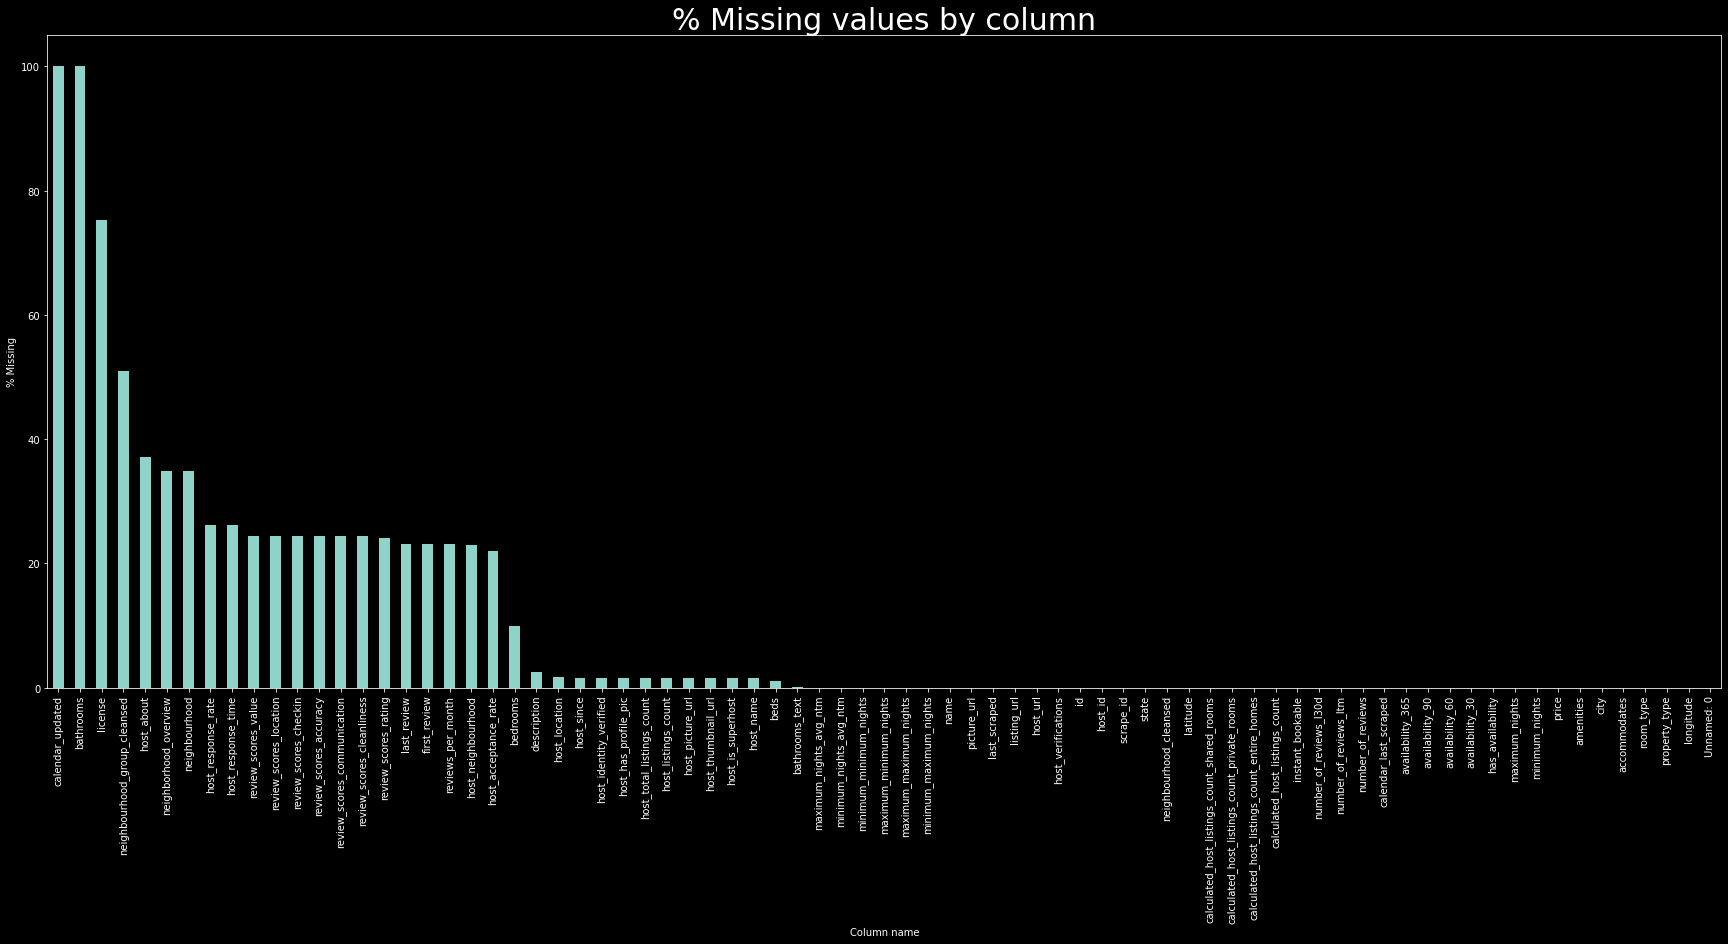

In [8]:
# count missing values
missing = pd.concat([airbnb.isnull().sum(), 100 * airbnb.isnull().mean()], axis=1)
missing.columns=['count', '%']

# Plot misssing values
missing['%'].sort_values(ascending=False).plot(kind='bar', figsize=(30,12))
plt.rc('font', size = 25)
plt.title('% Missing values by column')
plt.xlabel('Column name')
plt.ylabel('% Missing')

In [18]:
missing.loc[missing['%'].between(5, 100, inclusive=True)].sort_values('%', ascending=False)

# It appears that all 10 of the review features are likely related, with % missing 23 - 24%
# All of these may be missing for same rows if no reviews
# host_response_time and rate are likely related at 26%, and could apply to listings with < 2 contacts
# neighbourhood is irrelevant
# other variables here indicate the host did not fully complete the profile


count           %
bathrooms                     201584  100.000000
calendar_updated              201584  100.000000
license                       151644   75.226208
neighbourhood_group_cleansed  102799   50.995615
host_about                     74836   37.123978
neighborhood_overview          70378   34.912493
neighbourhood                  70374   34.910509
host_response_time             52673   26.129554
host_response_rate             52673   26.129554
review_scores_value            49341   24.476645
review_scores_location         49333   24.472676
review_scores_checkin          49329   24.470692
review_scores_accuracy         49291   24.451841
review_scores_communication    49288   24.450353
review_scores_cleanliness      49274   24.443408
review_scores_rating           48669   24.143285
first_review                   46761   23.196781
last_review                    46761   23.196781
reviews_per_month              46761   23.196781
host_neighbourhood             46164   22.900627
host_acceptance_rate           44379   22.015140
bedrooms                       20116    9.978967

In [35]:
missing.loc[missing['%'].between(0.5, 4, inclusive=True)].sort_values('%', ascending=False)


count         %
description                 4942  2.451583
host_location               3618  1.794785
host_name                   3215  1.594869
host_since                  3215  1.594869
host_is_superhost           3215  1.594869
host_thumbnail_url          3215  1.594869
host_picture_url            3215  1.594869
host_listings_count         3215  1.594869
host_total_listings_count   3215  1.594869
host_has_profile_pic        3215  1.594869
host_identity_verified      3215  1.594869
beds                        2320  1.150885

#### 2.2.1 Missing values - Findings<a id='2.2.1_Missing_Values_Findings'></a>

**Columns > 40% missing values:**
- four columns are > 40% missing, check for problem with data extaction
  - check data dictionary, then open datasets for single cities using different software and check these columns
  - OK, it looks like these values are also missing from my raw data, 
  - drop 100% missing columns

- License and neighbourhood_group_cleansed:
  - convert license to boolean
  - in neighbourhood_group_cleansed replace NA with city name
  
**Columns with 10 - 50% missing**
  - It appears that all 10 of the review features are likely related, with % missing 23 - 24%
  - All of these may be missing for same rows if no reviews
  - host_response_time and rate are likely related at 26%, and could apply to listings with < 2 contacts
  - neighbourhood is irrelevant
  - other variables here indicate the host did not fully complete the profile

**Target variable**
-Price has no missing values

**Drop**
- Features: 'neighbourhood', 'bathrooms', 'calendar_updated'

- Rows: drop all where host_verified is not True, since host_verification is an Airbnb requirement




In [11]:
airbnb.shape

(201584, 77)

In [12]:
## Fix license, neighbourhood_group_cleansed
# license --> boolean
airbnb['license'] = airbnb['license'].notna()

# Fill missing neighborhood_group_cleansed with city name
airbnb.neighbourhood_group_cleansed.fillna(airbnb.city, inplace = True)
airbnb['neighbourhood_group_cleansed'].head()

# Drop unverified hosts
airbnb = airbnb[airbnb['host_identity_verified'] == 't']
airbnb.shape

0    asheville
1    asheville
2    asheville
3    asheville
4    asheville
Name: neighbourhood_group_cleansed, dtype: object

(159215, 77)

In [36]:
airbnb.shape

(159215, 83)

### 2.3 Review Variables<a id='2.3_Review_Variables'></a>
- Review variables by type and group them

#### 2.3.1 Location Data<a id='2.3.1_Location_Data'></a>

**Objectives**
- Create list of location data
- Note feature importance
- Transform geospatial data into a form that is amenable for machine learning
  - Ex. distance from listings to potential landmarks or attractions

##### Location variables

spatial_all = 'city', 'state', 'neighborhood_overview', 'host_location', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',  'km_from_city_center', 'latitude', 'longitude', 


**most useful**
coordinates = 'latitude', 'longitude'
- engineer into 'distance_from_city_center'



categorical = 'city', 'state', 'neighborhood_cleansed'

**questionable**
- 'neighborhood_overview', a text description
- 'host_location', convert to 'host_is_local' or 'host_proximity' if time

**drop**
- 'neighbourhood_group_cleansed', 'host_neighbourhood', 'neighbourhood'






##### Location feature processing:
- Feature: distance from city center
- Rationale:
  - City centers often contain many attractions and resources that visitors seek to utilize:
    - convention centers, transportation hubs, nightlife, markets, 
  - After a period of disinvestment there has been renewed interest in city centers
  - City center coordinates are straightforward to find
    - https://amaral.northwestern.edu/blog/getting-long-lat-list-cities

- Optional: distance to other landmarks?
  - More difficult, though I did find a wikipedia table of most visited tourist attractions in U.S.
    - https://en.wikipedia.org/wiki/Tourist_attractions_in_the_United_States
  - I could theoretically find the coordinates for many of these by scraping urls, then following the urls and scraping the next page for coordinates
  - Drawbacks:
    - not all cities have tourist attractions in this page
    - most of the information value may already be present in neighborhood_name, city, and distance_to_center features


In [27]:
## Recreate 'city_state' df
city_state = airbnb[['city', 'state']].drop_duplicates()

len(city_state)

28

In [28]:
## Get coordinates for city centers

## Preparation: revist initial url scraping, extract 'city' and 'state' from url
# and input these values into dataframe city_state
# use city_state to get coordinates for cities (city names alone are not unique)
# append both state and coordinates to airbnb dataframe

from opencage.geocoder import OpenCageGeocode
from pprint import pprint

key = 'cd7e8222aabc4d99be25e5ab254cdea9'
geocoder = OpenCageGeocode(key)

list_lat = []   # create empty lists
list_long = []

for index, row in city_state.iterrows(): # iterate over rows in dataframe

    City = row['city']
    State = row['state']       
    query = str(City)+','+str(State)

    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']

    list_lat.append(lat)
    list_long.append(long)

# create new columns from lists    

city_state['city_lat'] = list_lat   
city_state['city_lon'] = list_long

In [29]:
# merge into dataframe
airbnb=pd.merge(airbnb, city_state, how='left', on=['city', 'state'])

In [30]:
# Define function for calculating haversine distances
def haversine_vectorize(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    newlat = lat2 - lat1
    newlon = lon2 - lon1
    
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
    
    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    km = 6367 *dist #6367 for distance in KM for miles use 3958
    
    return km

In [31]:
# Calculate distance from listing to city center in km
airbnb['km_from_city_center']= haversine_vectorize(airbnb['latitude'],airbnb['longitude'],airbnb['city_lat'],
                   airbnb['city_lon']) # Rename km_to_citycenter

In [48]:
airbnb.shape

(159215, 79)

In [49]:
# drop unneeded spatial variables
airbnb = airbnb.drop(['latitude', 'longitude', 'city_lat', 'city_lon'], axis =1)

airbnb.shape

(159215, 75)

In [52]:
airbnb = airbnb.drop(['host_neighbourhood', 'neighbourhood', 
                      'neighbourhood_group_cleansed'], axis = 1)

In [53]:
airbnb.shape

(159215, 72)

### 2.3.1.1 Save progress

Save spatial features before continuing

In [33]:
## Save progress: 
datapath = r"C:\Users\forre\Data science projects\GIT local\Capstone 2\Raw data\airbnb_processed.csv"

airbnb.to_csv(datapath)

In [2]:
# load data with geospatial
datapath = r"C:\Users\forre\Data science projects\GIT local\Capstone 2\Raw data\airbnb_processed.csv"
airbnb = pd.read_csv(datapath)


C:\Users\forre\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (29,30,69) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
airbnb.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'listing_url', 'scrape_id',
       'last_scraped', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'm

### 2.3.2 Listing Data<a id='2.3.2_Listing_Data'></a>

**Text to process:**
- 'amenities': json containing list of lists with regular expressions in quotes
  - ex. 'parking on premises', 'washer and dryer'
  - Need to one-hot encode, this could be valuable

- 'description'

- 'bathrooms' 

Useful categorical:
- 'room_type', 'property_type', 'bedrooms', etc
  

Questionable:
- 'name', 

Drop:
- 'picture_url'


### 2.3.3 Host Data<a id='2.3.3_Host_Data'></a>

Host activity:
- 'host_since', (date)
- 'host_response_time', 'response_rate', 'superhost', etc


Questionable:
- 'host_about', 'listings_count' and sub-features


Drop:
- 'host_name', 'host_url', 'host_picture_url', 'host_thumbnail_url', 'host_verifications', 

Drop after processing:
- 'host_id'

In [ ]:
airbnb = airbnb.drop(['listing_url', 'scrape_id', 'bathrooms', 'host_url', 'picture_url', 'host_thumbnail_url', 'host_picture_url'], axis = 1)
airbnb.shape

### 2.3.4 Review Data<a id='2.3.4_Review_Data'></a>


**Review-related variables**
* Most of these contain ~ 22% missing values, since these listings lack reviews
* review_vars = 'review_scores_value', 'review_scores_location', 'review_scores_checkin',
              'review_scores_accuracy', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_rating'
              
**How to fix:**
- I assume that the absence of reviews would affect price because people like use reviews to build trust in the host
- I also want to keep the review scores since they could be useful to differentiate between price of similar listings

Approach: 
- use number_of_reviews variable
- keep review scores variables and experiment with:
    - impute median and impute most frequent
              
**Dates**
- first_review, last_review; processed below
 

### 2.3.5 Dates<a id='2.3.5_Dates'></a>

date_vars: host_since, calendar_updated, calendar_last_scraped, first_review, last_review


#### Created features
- days_as_host
- days_since_first_review
- days_since_last_review

#### Dropped date features

- 'calendar_updated', 
-after feature engineering: 'last_scraped', 'host_since', 'first_review', 'last_review'


In [34]:
## create 'days_as_host' variable
from datetime import datetime
from datetime import timedelta

airbnb.last_scraped = [datetime.strptime(x, '%Y-%m-%d') for x in airbnb.last_scraped]
airbnb.host_since = pd.to_datetime(airbnb.host_since, errors = 'coerce')
airbnb.first_review = pd.to_datetime(airbnb.first_review, errors = 'coerce')
airbnb.last_review = pd.to_datetime(airbnb.last_review, errors = 'coerce')

airbnb['days_as_host'] = airbnb.last_scraped - airbnb.host_since
airbnb['days_since_first_review'] = airbnb.last_scraped - airbnb.first_review
airbnb['days_since_last_review'] = airbnb.last_scraped - airbnb.last_review


In [38]:
# drop rows with missing 'host_since'
airbnb = airbnb[pd.notnull(airbnb['host_since'])]
airbnb.shape

(159215, 83)

In [45]:
# check on  date conversions
airbnb[['last_scraped', 'host_since', 'first_review', 'last_review']].head(-5)


last_scraped host_since first_review last_review
0        2021-03-16 2010-12-16   2011-09-21  2019-11-30
1        2021-03-12 2011-08-28   2011-09-19  2021-01-09
2        2021-03-16 2011-09-01   2012-05-29  2019-11-30
3        2021-03-13 2011-12-13   2012-01-13  2020-10-10
4        2021-03-11 2011-04-02   2012-06-04  2021-03-07
...             ...        ...          ...         ...
159205   2021-03-12 2021-01-26          NaT         NaT
159206   2021-03-12 2021-01-26          NaT         NaT
159207   2021-03-12 2014-10-31          NaT         NaT
159208   2021-03-14 2013-12-03          NaT         NaT
159209   2021-03-12 2018-08-04          NaT         NaT

[159210 rows x 4 columns]

In [46]:
airbnb[['days_as_host', 'days_since_first_review', 'days_since_last_review']].head()

days_as_host days_since_first_review days_since_last_review
0    3743 days               3464 days               472 days
1    3484 days               3462 days                62 days
2    3484 days               3213 days               472 days
3    3378 days               3347 days               154 days
4    3631 days               3202 days                 4 days

In [47]:
# remove old date columns:
airbnb = airbnb.drop(['last_scraped', 'host_since', 'first_review', 'last_review'], axis =1)
airbnb.drop(['calendar_updated'], axis = 1)

In [75]:
# convert timedelta to integer

airbnb['days_as_host'].dtype

dtype('<m8[ns]')

In [80]:
airbnb['days_as_host']=airbnb['days_as_host'].dt.days
airbnb['days_since_first_review']=airbnb['days_since_first_review'].dt.days
airbnb['days_since_last_review']=airbnb['days_since_last_review'].dt.days


### 2.4 Summary<a id='2.4_Summary'></a>

* Here I review the column datatypes and summarize the numeric features
* I see that there are several columns which will need to be converted to numeric for EDA


#### Strategy for EDA<a id='2.4.1_Strategy_for_EDA'></a>
* Text data, 
  * Select potentially useful text variables
  * Process, model, and extract most predictive subset

* Objects to numeric
  * Convert potentially useful object data to numeric
  * Plot numeric distributions

* Correlations
  * Check for correlated features, select representative features from within the correlated groups for modelling

* Less relevant features
  * Can keep less relevant numeric features through first pass of feature selection
  * Keep a list of these for quick elimination during modelling
  * Set aside less relevant non-numeric features, as these would likely require more processing than they are worth. I can add back if needed later
  







In [81]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159215 entries, 0 to 159214
Data columns (total 65 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Unnamed: 0                                    159215 non-null  int64  
 1   id                                            159215 non-null  int64  
 2   name                                          159203 non-null  object 
 3   description                                   155457 non-null  object 
 4   neighborhood_overview                         104565 non-null  object 
 5   host_id                                       159215 non-null  int64  
 6   host_name                                     159215 non-null  object 
 7   host_location                                 159123 non-null  object 
 8   host_about                                    107671 non-null  object 
 9   host_response_time                            12

In [58]:
airbnb.describe().T

count  \
Unnamed: 0                                    159215   
id                                            159215   
scrape_id                                     159215   
host_id                                       159215   
host_listings_count                           159215   
host_total_listings_count                     159215   
accommodates                                  159215   
bathrooms                                          0   
bedrooms                                      143241   
beds                                          157286   
minimum_nights                                159215   
maximum_nights                                159215   
minimum_minimum_nights                        159196   
maximum_minimum_nights                        159196   
minimum_maximum_nights                        159196   
maximum_maximum_nights                        159196   
minimum_nights_avg_ntm                        159196   
maximum_nights_avg_ntm                        159196   
calendar_updated                                   0   
availability_30                               159215   
availability_60                               159215   
availability_90                               159215   
availability_365                              159215   
number_of_reviews                             159215   
number_of_reviews_ltm                         159215   
number_of_reviews_l30d                        159215   
review_scores_rating                          120930   
review_scores_accuracy                        120393   
review_scores_cleanliness                     120409   
review_scores_checkin                         120362   
review_scores_communication                   120396   
review_scores_location                        120358   
review_scores_value                           120352   
calculated_host_listings_count                159215   
calculated_host_listings_count_entire_homes   159215   
calculated_host_listings_count_private_rooms  159215   
calculated_host_listings_count_shared_rooms   159215   
reviews_per_month                             122236   
km_from_city_center                           159215   
days_as_host                                  159215   
days_since_first_review                       122236   
days_since_last_review                        122236   

                                                                   mean  \
Unnamed: 0                                                       100605   
id                                                          2.85566e+07   
scrape_id                                                   2.02103e+13   
host_id                                                     1.00285e+08   
host_listings_count                                             86.1316   
host_total_listings_count                                       86.1316   
accommodates                                                    3.92518   
bathrooms                                                           NaN   
bedrooms                                                        1.67311   
beds                                                            2.11299   
minimum_nights                                                  642.205   
maximum_nights                                                  15505.7   
minimum_minimum_nights                                          642.383   
maximum_minimum_nights                                           649.73   
minimum_maximum_nights                                      1.48602e+06   
maximum_maximum_nights                                      2.64614e+06   
minimum_nights_avg_ntm                                          648.529   
maximum_nights_avg_ntm                                      2.49729e+06   
calendar_updated                                                    NaN   
availability_30                                                  10.405   
availability_60                                                

In [61]:
# No missing values in price
missing_price = airbnb['price'].isnull().sum()
missing_price

0

## 2.5 Save Processed Data<a id='2.5_Save_Processed_Data'></a>

In [83]:
## Save progress: 
datapath = r"C:\Users\forre\Data science projects\GIT local\Capstone 2\Raw data\airbnb_processed.csv"

airbnb.to_csv(datapath)